# Flood Prediction - Datenvorbereitung

In this first notebook, the data is prepared, cleaned and additional features are added.

In [22]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl
%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns # special graphic representations
import statsmodels.api as sm
import statsmodels.stats.api as sms

from sklearn.preprocessing import StandardScaler

First, we should always get an overview of the available data and identify important features.
Let's start with the first of the two datasets: "pr_hourly_DWD_ID1550.dat". This dataset provides hourly measured precipitation values.

In [3]:
Daten_pr = pd.read_csv("pr_hourly_DWD_ID1550.dat", sep="\t", names=['Year','Month','Day','Hour','pr'])

Daten_pr.head()

Year  Month  Day  Hour   pr
0  1995      9    1     0  0.0
1  1995      9    1     1  0.0
2  1995      9    1     2  0.0
3  1995      9    1     3  0.0
4  1995      9    1     4  0.0

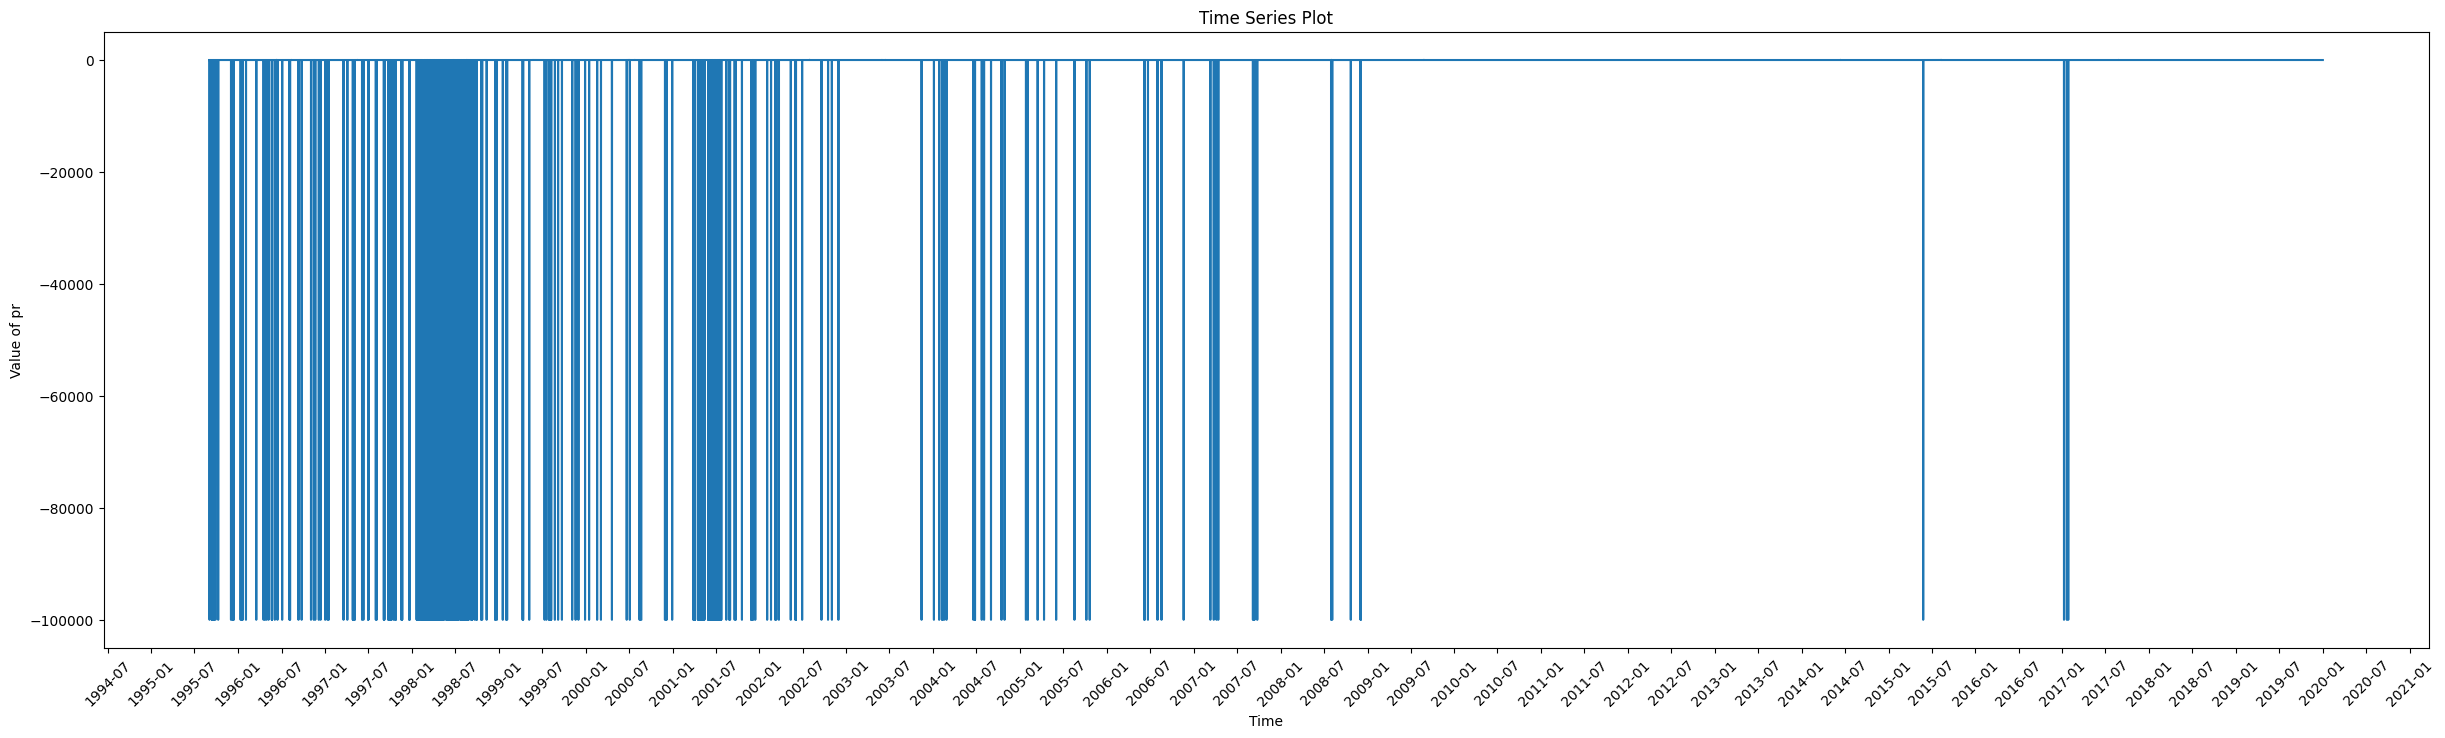

In [4]:
# Plot of the complete time series

import matplotlib.dates as mdates

Daten_pr['Timestamp'] = pd.to_datetime(Daten_pr[['Year', 'Month', 'Day', 'Hour']])

plt.figure(figsize=(30, 8))
plt.plot(Daten_pr['Timestamp'], Daten_pr['pr'])
plt.xlabel('Time')
plt.ylabel('Value of pr')
plt.title('Time Series Plot')

# Locator and Formatter to properly label the x-axis
custom_locator = mdates.MonthLocator(bymonth=[1, 7])  # Nur January (1) and July (7)
plt.gca().xaxis.set_major_locator(custom_locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format: Year-Month

plt.xticks(rotation=45)  # Rotate axis for better readability
plt.show()

It quickly becomes apparent that there are some erroneous values (possibly just missing data that was entered with the value -99999 in the dataset). What should we do with this data? Simply deleting it wouldn't be a good idea since it would make the time series incomplete. One consideration would be to keep the data points and simply set them to zero. However, this would be problematic as it would no longer optimally represent the relationship between precipitation and water level.
Therefore, our approach was to compensate for these missing data points using linear interpolation.

In [5]:
Daten_pr['pr'] = Daten_pr['pr'].replace(-99999, np.nan)
Daten_pr['pr'] = Daten_pr['pr'].interpolate(methode='linear')

In [6]:
print(Daten_pr['pr'].unique()) # displays a list of all unique values (to get an overview of the value range)

[0.00000000e+00 1.00000000e-01 2.00000000e-01 3.00000000e-01
 8.00000000e-01 5.00000000e-01 1.00000000e+00 3.40000000e+00
 2.20000000e+00 1.20000000e+00 4.00000000e-01 7.00000000e-01
 6.00000000e-01 1.90000000e+00 2.00000000e+00 1.50000000e+00
 1.60000000e+00 5.00000000e-02 1.10000000e+00 4.00000000e+00
 9.00000000e-01 1.80000000e+00 1.70000000e+00 1.40000000e+00
 1.30000000e+00 2.80000000e+00 2.10000000e+00 2.40000000e+00
 4.80000000e+00 3.30000000e+00 5.50000000e-01 6.00000000e-01
 2.60000000e+00 2.50000000e+00 3.00000000e+00 2.70000000e+00
 3.60000000e+00 3.10000000e+00 3.50000000e+00 3.20000000e+00
 7.10000000e+00 2.90000000e+00 3.90000000e+00 7.40000000e+00
 2.30000000e+00 5.50000000e+00 7.30000000e+00 3.70000000e+00
 4.50000000e+00 2.96000000e+01 7.80000000e+00 5.00000000e+00
 4.20000000e+00 4.60000000e+00 1.07000000e+01 1.14000000e+01
 9.10000000e+00 5.30000000e+00 2.11000000e+01 6.50000000e+00
 5.20000000e+00 3.80000000e+00 4.70000000e+00 6.10000000e+00
 5.80000000e+00 6.700000

Now it's clear that only positive values for precipitation are present within our data. The cleaned dataset is now plotted again. 

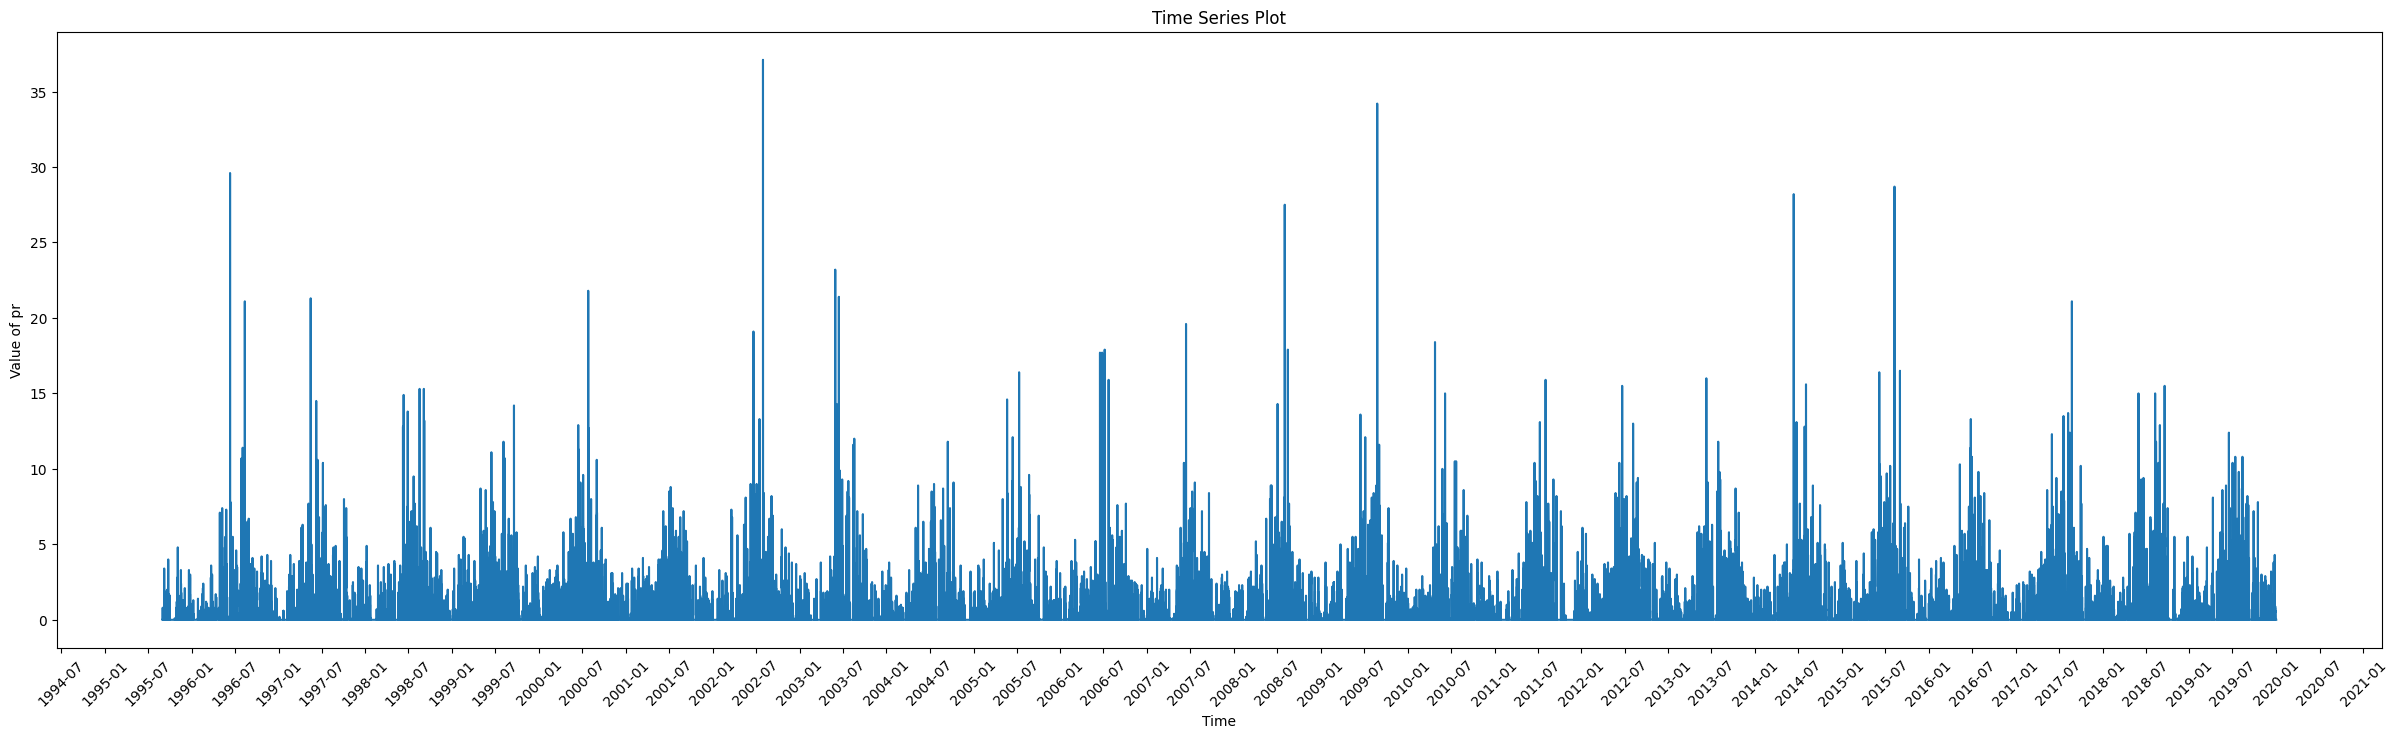

In [7]:
import matplotlib.dates as mdates

Daten_pr['Timestamp'] = pd.to_datetime(Daten_pr[['Year', 'Month', 'Day', 'Hour']])

plt.figure(figsize=(30, 8))
plt.plot(Daten_pr['Timestamp'], Daten_pr['pr'])
plt.xlabel('Time')
plt.ylabel('Value of pr')
plt.title('Time Series Plot')

custom_locator = mdates.MonthLocator(bymonth=[1, 7]) 
plt.gca().xaxis.set_major_locator(custom_locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

plt.xticks(rotation=45) 
plt.show()

Now we're going to do the same with the second dataset, which indicates the water level ("Q_hourly_ID16425004.dat")

In [8]:
Daten_Q = pd.read_csv("Q_hourly_ID16425004.dat", sep=",")

print(Daten_Q['Q'].unique())
Daten_Q.head()

[ 2.46   2.58   4.5   ... 11.329 13.116 15.51 ]


Year  Month  Day  Hour     Q
0  1920     11    1     0  2.46
1  1920     11    1     1  2.46
2  1920     11    1     2  2.46
3  1920     11    1     3  2.46
4  1920     11    1     4  2.46

The values of Q appear plausible at first glance, so they do not need to be cleaned. However, the time series does not match the previous dataset in terms of the time period. This needs to be adjusted.

Plot this dataset: 

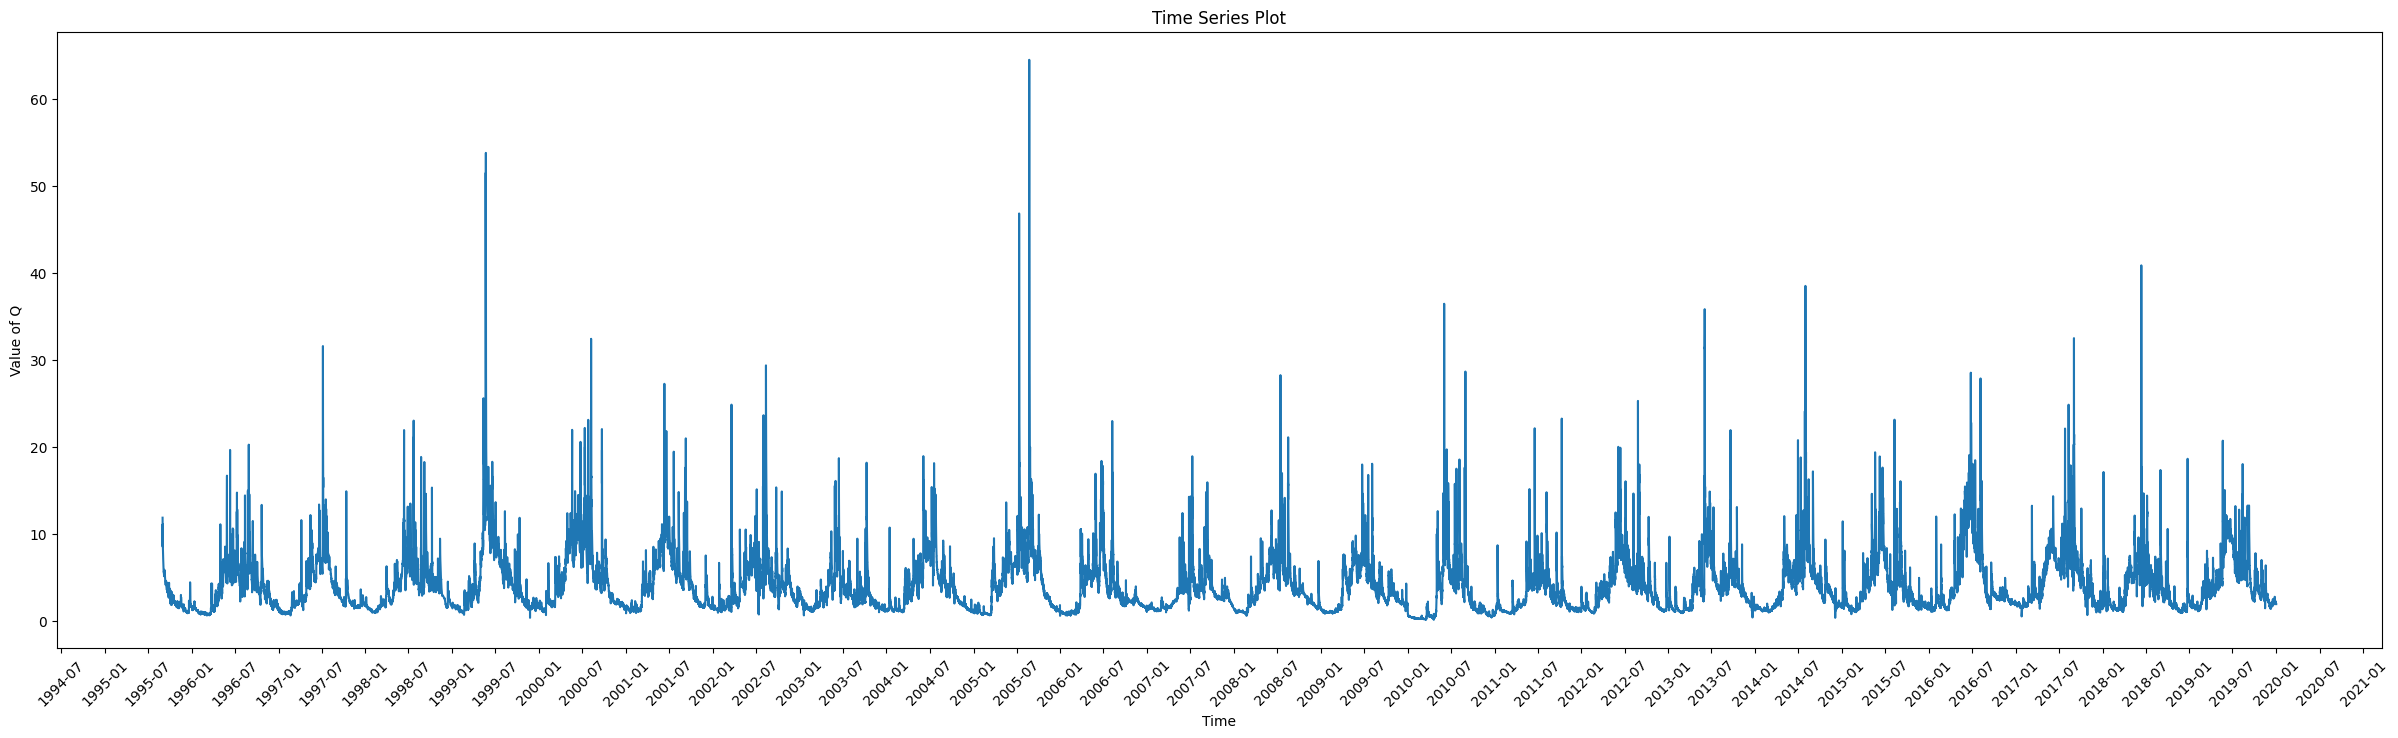

In [9]:
# Zeitfenster vom Q-Datensatz anpassen 
start_date = pd.to_datetime('1995-09-01 00:00')
end_date = pd.to_datetime('2019-12-31 23:00')

Daten_Q['Timestamp'] = pd.to_datetime(Daten_Q[['Year', 'Month', 'Day', 'Hour']])

Daten_Q = Daten_Q[(Daten_Q['Timestamp'] >= start_date) & (Daten_Q['Timestamp'] <= end_date)]


# Plot von Q
plt.figure(figsize=(30, 8))
plt.plot(Daten_Q['Timestamp'], Daten_Q['Q'])
plt.xlabel('Time')
plt.ylabel('Value of Q')
plt.title('Time Series Plot')

custom_locator = mdates.MonthLocator(bymonth=[1, 7])  
plt.gca().xaxis.set_major_locator(custom_locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

plt.xticks(rotation=45)  
plt.show()

Now we can merge the data into a single dataframe and then plot the two features on top of each other. 

In [10]:
Daten = pd.merge(Daten_Q[['Timestamp', 'Q']], Daten_pr[['Timestamp', 'pr']], on='Timestamp', how='inner')
Daten['year'] = Daten['Timestamp'].dt.year
Daten['month'] = Daten['Timestamp'].dt.month
Daten['day'] = Daten['Timestamp'].dt.day
Daten['hour'] = Daten['Timestamp'].dt.hour

Daten = Daten[['year', 'month', 'day', 'hour', 'Q', 'pr', 'Timestamp']]

Daten.head()

year  month  day  hour       Q   pr           Timestamp
0  1995      9    1     0  11.888  0.0 1995-09-01 00:00:00
1  1995      9    1     1  11.745  0.0 1995-09-01 01:00:00
2  1995      9    1     2  11.601  0.0 1995-09-01 02:00:00
3  1995      9    1     3  11.457  0.0 1995-09-01 03:00:00
4  1995      9    1     4  11.313  0.0 1995-09-01 04:00:00

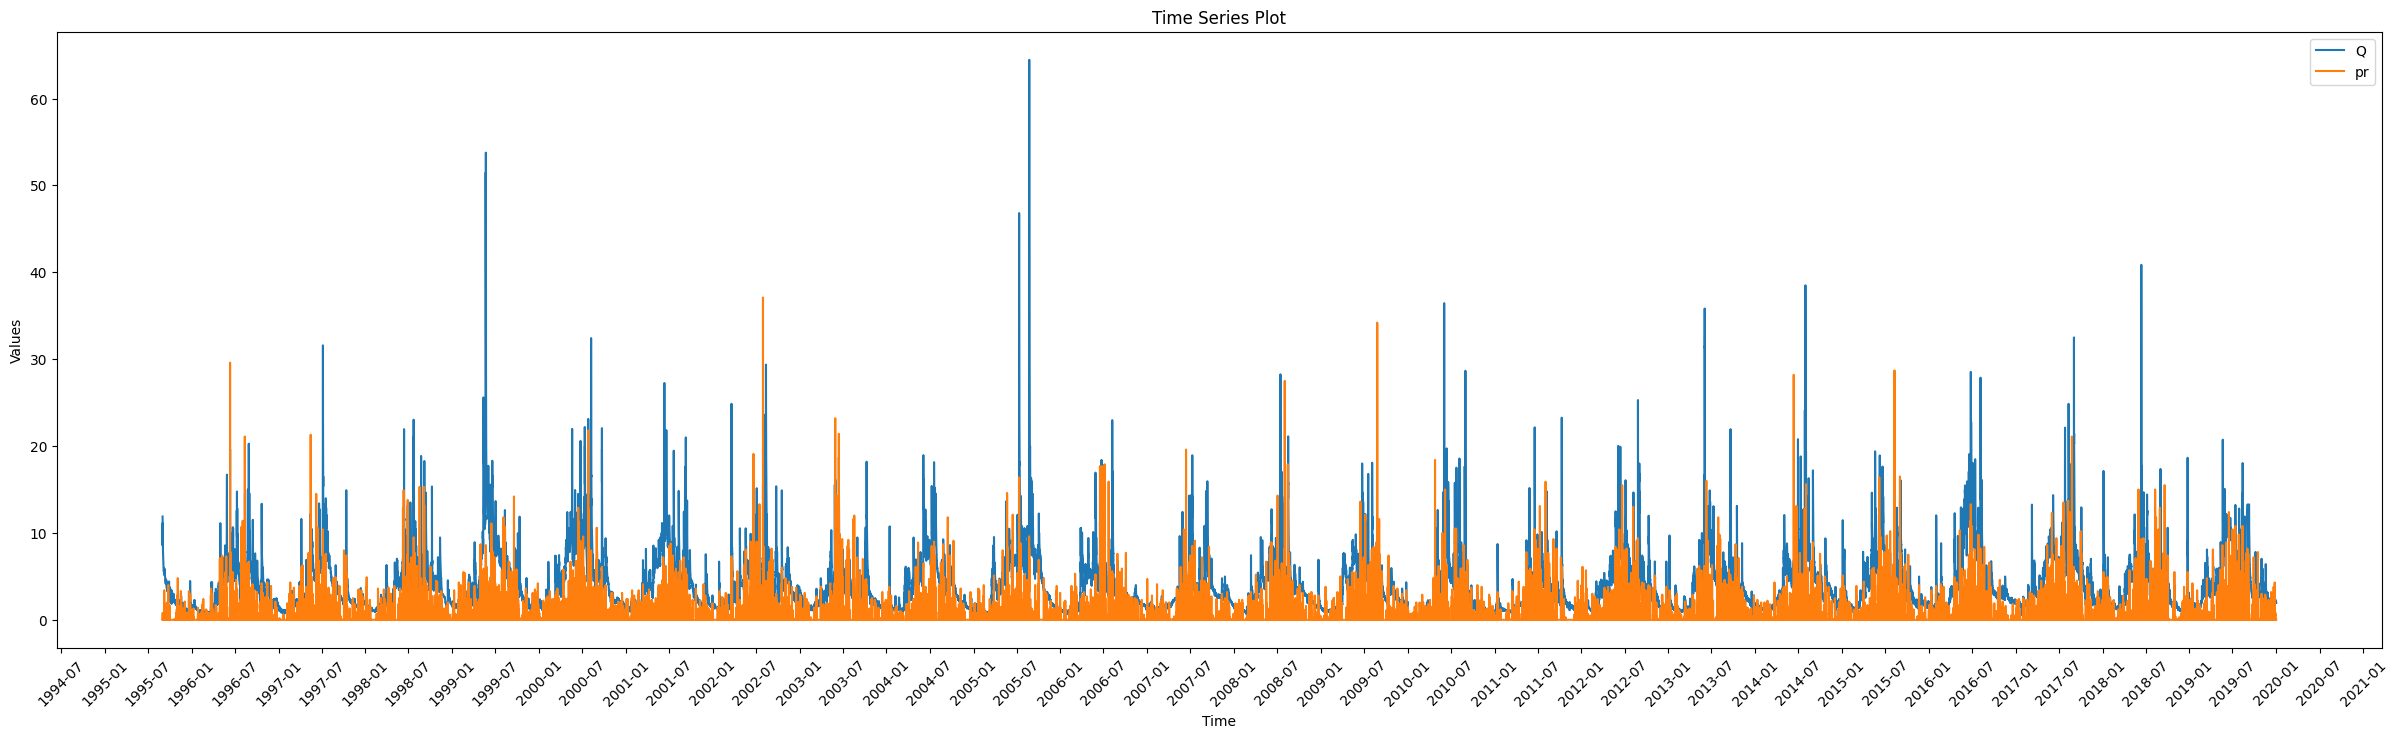

In [11]:
plt.figure(figsize=(30, 8))
plt.plot(Daten['Timestamp'], Daten['Q'], label="Q")
plt.plot(Daten['Timestamp'], Daten['pr'], label="pr")
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Time Series Plot')
plt.legend()

custom_locator = mdates.MonthLocator(bymonth=[1, 7])  
plt.gca().xaxis.set_major_locator(custom_locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

plt.xticks(rotation=45)  
plt.show()

## Adding new Features

In the next step, additional features will be added, as precipitation and Q alone are not sufficient. We need time-lag features and also aggregated statistics (e.g., total precipitation over the last 12 hours)

In [12]:
for lag in range(1, 7):
    # Lag Features (Water Level and Precipitation from (lag) hours ago)
    Daten[f'Q_lag_{lag}'] = Daten['Q'].shift(lag)

    # Water Level Differences of the Last 6 Hours (Always from t to Time Point t-lag)
    Daten[f'Q_diff_lag_{lag}'] = Daten['Q'].diff(lag)

# Total Precipitation of the Last 6-24 Hours 
Daten['Total_pr_6h'] = Daten['pr'].rolling(window=6).sum()
Daten['Total_pr_12h'] = Daten['pr'].rolling(window=12).sum()
Daten['Total_pr_24h'] = Daten['pr'].rolling(window=24).sum()

# Water Level Change within the Last 6-24h
Daten['Total_Q_6h'] = Daten['Q'].rolling(window=6).sum()
Daten['Total_Q_12h'] = Daten['Q'].rolling(window=12).sum()
Daten['Total_Q_24h'] = Daten['Q'].rolling(window=24).sum()

# Moving Averages 
Daten['rolling_mean_Q_3h'] = Daten['Q'].rolling(window=3).mean()
Daten['rolling_mean_Q_6h'] = Daten['Q'].rolling(window=6).mean()

Daten['rolling_mean_pr_3h'] = Daten['pr'].rolling(window=3).mean()
Daten['rolling_mean_pr_6h'] = Daten['pr'].rolling(window=6).mean()

# Exponential Smoothing
Daten['exp_smooth_Q_3h'] = Daten['Q'].ewm(span=3).mean()
Daten['exp_smooth_pr_3h'] = Daten['pr'].ewm(span=3).mean()

# Ratio of Precipitation to Discharge 
Daten['pr_to_Q_ratio'] = Daten['pr'] / Daten['Q']

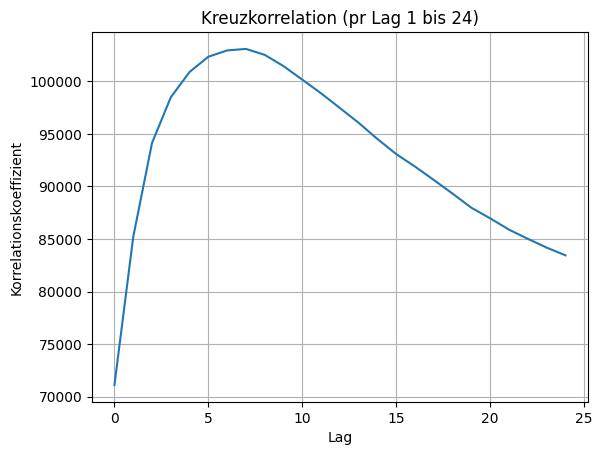

Maximum correlation is 103071.72298708207 at lag t = 7


In [14]:
# Find pr-lag with the highest correlation

x = Daten["Q"]
y = Daten["pr"]

# Cross-correlation
cross_corr_full = np.correlate(x - np.mean(x), y - np.mean(y), mode='full')

# Calculate lags
full_lags = np.arange(-len(x) + 1, len(x))  # All possible shifts
positive_lags = full_lags[len(x)-1:]        # Only positive shifts (Lag >= 0)

# Filter for lags 0 to 24
filtered_lags = positive_lags[0:25]  # Lags from 0 to 24 (including Lag = 0)
filtered_cross_corr = cross_corr_full[len(x)-1:len(x)+24]  # Corresponding correlation values for lags 0 to 24

plt.plot(filtered_lags, filtered_cross_corr)
plt.title("Cross-correlation (pr Lag 1 to 24)")
plt.xlabel("Lag")
plt.ylabel("Correlation Coefficient")
plt.grid()
plt.show()

max_corr = max(filtered_cross_corr)

max_corr = max(filtered_cross_corr)
max_lag = filtered_lags[np.argmax(filtered_cross_corr)]
print(f"Maximum correlation is {max_corr} at lag t = {max_lag}")

This experiment shows that the correlation at a shift of t = 7 (from pr) hours shows the highest correlation between Q and pr.

In [17]:
Daten['pr_lag_7'] = Daten['pr'].shift(periods=7)
Daten['pr_lag_year'] = Daten['pr'].shift(periods=3766)

Furthermore, seasonal variations must be taken into account, as there are certain months when the water level tends to be higher than in other months.

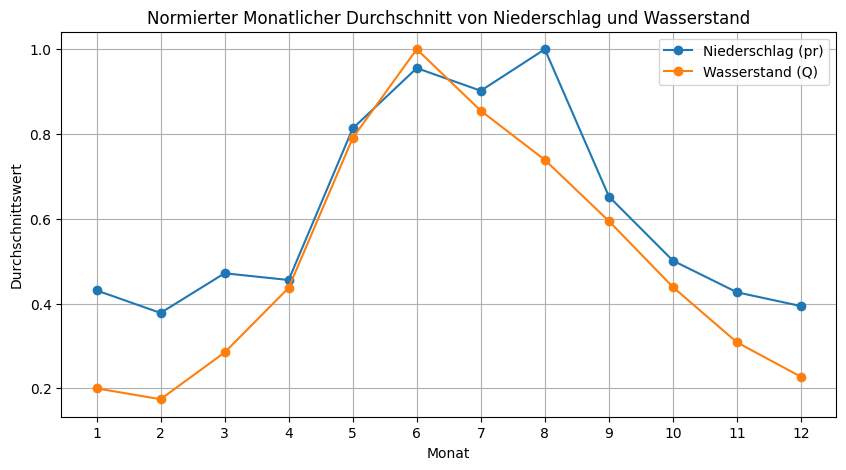

In [15]:
# Averages across all months 

monatsdurchschnitt_pr = Daten_pr.groupby('Month')['pr'].mean()
monatsdurchschnitt_q = Daten_Q.groupby('Month')['Q'].mean()

plt.figure(figsize=(10, 5))

plt.plot(monatsdurchschnitt_pr/max(monatsdurchschnitt_pr), label="Niederschlag (pr)", marker='o')
plt.plot(monatsdurchschnitt_q/max(monatsdurchschnitt_q), label="Wasserstand (Q)", marker='o')
plt.title("Normierter Monatlicher Durchschnitt von Niederschlag und Wasserstand")
plt.xlabel("Monat")
plt.ylabel("Durchschnittswert")
plt.xticks(range(1, 13))
plt.legend()
plt.grid()
plt.show()

This graph provides insight into which months have high precipitation or water levels and which do not, and that it makes sense to differentiate by months.

In [18]:
Daten['alltime_monthly_avg_pr'] = Daten_pr['alltime_month_avg']
Daten['alltime_monthly_avg_Q'] = Daten.groupby('month')['Q'].transform('mean')

This is what our DataFrame looks like now, including all new features: 

In [19]:
Daten

year  month  day  hour       Q   pr           Timestamp  Q_lag_1  \
0       1995      9    1     0  11.888  0.0 1995-09-01 00:00:00      NaN   
1       1995      9    1     1  11.745  0.0 1995-09-01 01:00:00   11.888   
2       1995      9    1     2  11.601  0.0 1995-09-01 02:00:00   11.745   
3       1995      9    1     3  11.457  0.0 1995-09-01 03:00:00   11.601   
4       1995      9    1     4  11.313  0.0 1995-09-01 04:00:00   11.457   
...      ...    ...  ...   ...     ...  ...                 ...      ...   
213307  2019     12   31    19   1.965  0.0 2019-12-31 19:00:00    1.965   
213308  2019     12   31    20   1.965  0.0 2019-12-31 20:00:00    1.965   
213309  2019     12   31    21   1.965  0.0 2019-12-31 21:00:00    1.965   
213310  2019     12   31    22   1.965  0.0 2019-12-31 22:00:00    1.965   
213311  2019     12   31    23   1.965  0.0 2019-12-31 23:00:00    1.965   

        Q_diff_lag_1  Q_lag_2  ...  rolling_mean_Q_6h  rolling_mean_pr_3h  \
0                NaN      NaN  ...                NaN                 NaN   
1             -0.143      NaN  ...                NaN                 NaN   
2             -0.144   11.888  ...                NaN                 0.0   
3             -0.144   11.745  ...                NaN                 0.0   
4             -0.144   11.601  ...                NaN                 0.0   
...              ...      ...  ...                ...                 ...   
213307         0.000    1.965  ...           1.964833                 0.0   
213308         0.000    1.965  ...           1.965000                 0.0   
213309         0.000    1.965  ...           1.965000                 0.0   
213310         0.000    1.965  ...           1.965000                 0.0   
213311         0.000    1.965  ...           1.965000                 0.0   

        rolling_mean_pr_6h  exp_smooth_Q_3h  exp_smooth_pr_3h  pr_to_Q_ratio  \
0                      NaN        11.888000      0.000000e+00            0.0   
1                      NaN        11.792667      0.000000e+00            0.0   
2                      NaN        11.683143      0.000000e+00            0.0   
3                      NaN        11.562533      0.000000e+00            0.0   
4                      NaN        11.433742      0.000000e+00            0.0   
...                    ...              ...               ...            ...   
213307                 0.0         1.964969      4.377262e-28            0.0   
213308                 0.0         1.964985      2.188631e-28            0.0   
213309                 0.0         1.964992      1.094315e-28            0.0   
213310                 0.0         1.964996      5.471577e-29            0.0   
213311                 0.0         1.964998      2.735789e-29            0.0   

        pr_lag_7  pr_lag_year  alltime_monthly_avg_pr  alltime_monthly_avg_Q  
0            NaN          NaN                0.163722               4.752226  
1            NaN          NaN                0.163722               4.752226  
2            NaN          NaN                0.163722               4.752226  
3            NaN          NaN                0.163722               4.752226  
4            NaN          NaN                0.163722               4.752226  
...          ...          ...                     ...                    ...  
213307       0.0          0.0                0.098868               1.815436  
213308       0.0          0.0                0.098868               1.815436  
213309       0.0          0.0                0.098868               1.815436  
213310       0.0          0.0                0.098868               1.815436  
213311       0.0          0.0                0.098868               1.815436  

[213312 rows x 36 columns]

Heatmap with the most important comparisons: 

                               Q   Q_lag_1  Q_diff_lag_1   Q_lag_2  \
pr                      0.160927  0.138549      0.245061  0.124756   
Gesamt_pr_6h            0.310027  0.286943      0.252711  0.261249   
Gesamt_pr_12h           0.391767  0.379070      0.139017  0.363878   
Gesamt_pr_24h           0.467537  0.462751      0.052391  0.456522   
rolling_mean_pr_3h      0.239526  0.208055      0.344556  0.179300   
rolling_mean_pr_6h      0.310027  0.286943      0.252711  0.261249   
exp_smooth_pr_3h        0.239674  0.210277      0.321938  0.186574   
pr_to_Q_ratio          -0.045756 -0.053678      0.086770 -0.057939   
pr_to_Q_ratio          -0.045756 -0.053678      0.086770 -0.057939   
pr_lag_7                0.233256  0.232929      0.003547  0.231575   
pr_lag_year            -0.042747 -0.042756      0.000109 -0.042830   
alltime_monthly_avg_pr  0.651427  0.651453     -0.000302  0.651486   

                        Q_diff_lag_2   Q_lag_3  Q_diff_lag_3   Q_lag_4  \
pr             

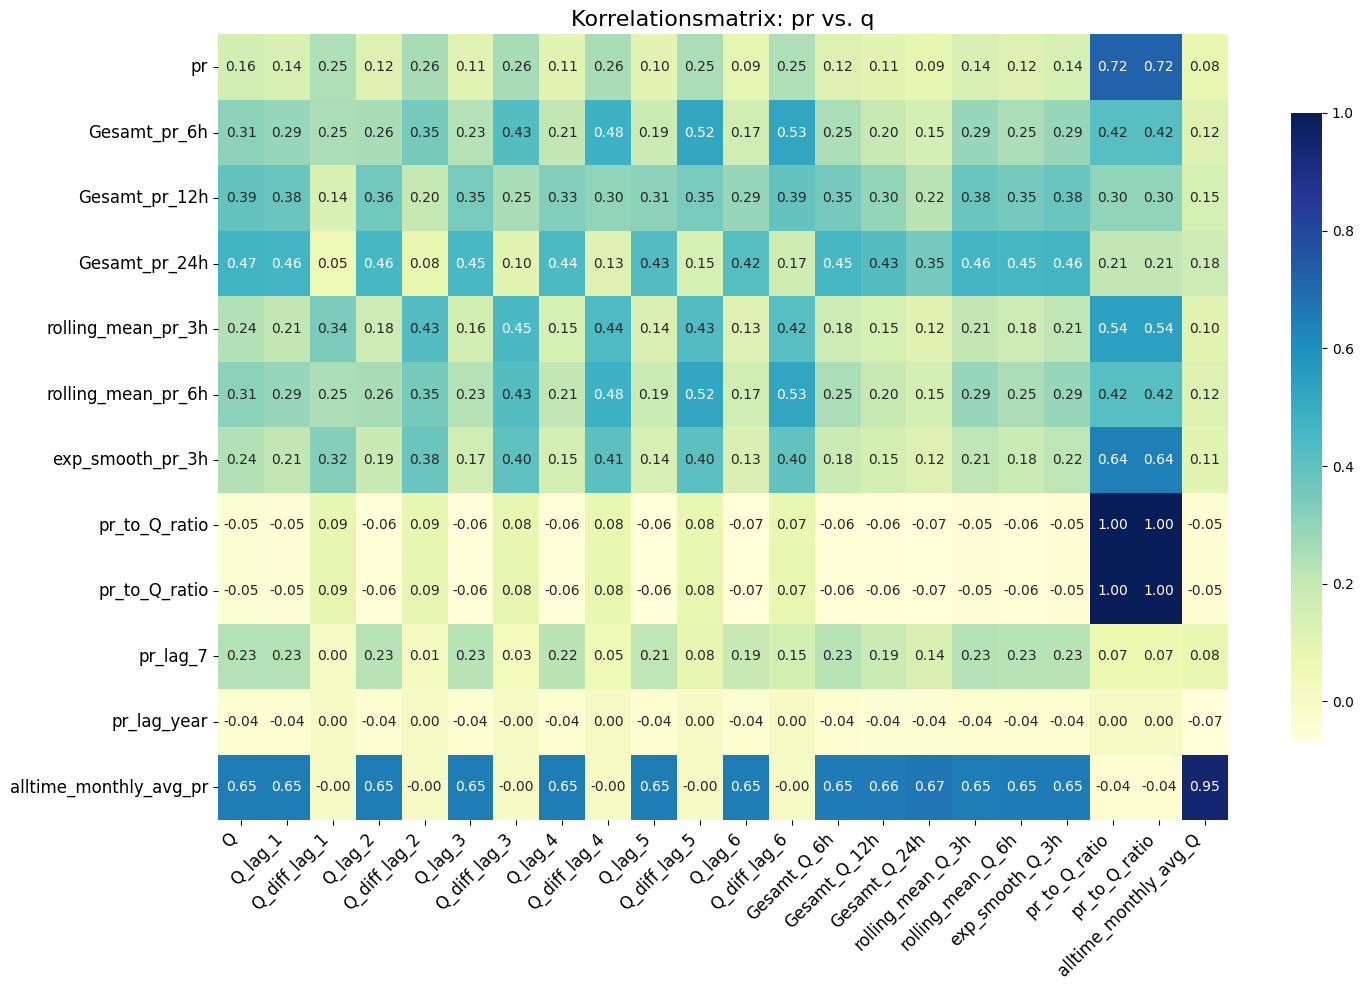

In [20]:
# Identify "pr"- und "q"-Columns
pr_spalten = [col for col in Daten.columns if "pr" in col.lower()]
q_spalten = [col for col in Daten.columns if "q" in col.lower()]

# Check data
if not pr_spalten or not q_spalten:
    print("Error: No matching columns found!")
else:
    # Calculate correlation matrix
    korrelation_pr_q = Daten[pr_spalten + q_spalten].corr().loc[pr_spalten, q_spalten]
    print(korrelation_pr_q)

    # Check if the correlation matrix is empty
    if korrelation_pr_q.empty:
        print("Error: The correlation Matrix is empty!")
    else:
        # Plot heatmap
        plt.figure(figsize=(15, 10))
        sns.heatmap(
            korrelation_pr_q,
            cmap="YlGnBu",
            annot=True,
            fmt=".2f",
            annot_kws={"size": 10},
            cbar_kws={"shrink": 0.8}
        )
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.title("Correlation Matrix: pr vs. q", fontsize=16)
        plt.tight_layout()
        plt.show()

## Feature Selection: 
In the end, we decided on the following features: 

In [21]:
Daten = Daten[['Q', 'pr', 'Q_lag_1',
       'Q_lag_2', 'Q_lag_4', 'Q_lag_6',
       'Gesamt_pr_6h', 'Gesamt_pr_12h', 'Gesamt_pr_24h',
       'Gesamt_Q_6h', 'Gesamt_Q_12h', 'Gesamt_Q_24h', 
       'rolling_mean_Q_6h', 'rolling_mean_pr_6h',
       'exp_smooth_Q_3h', 'exp_smooth_pr_3h', 'pr_to_Q_ratio',
       'alltime_monthly_avg_pr', 'alltime_monthly_avg_Q', 'pr_lag_7']]

In [23]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(Daten)
scaled_df = pd.DataFrame(data_scaled, columns=Daten.columns)

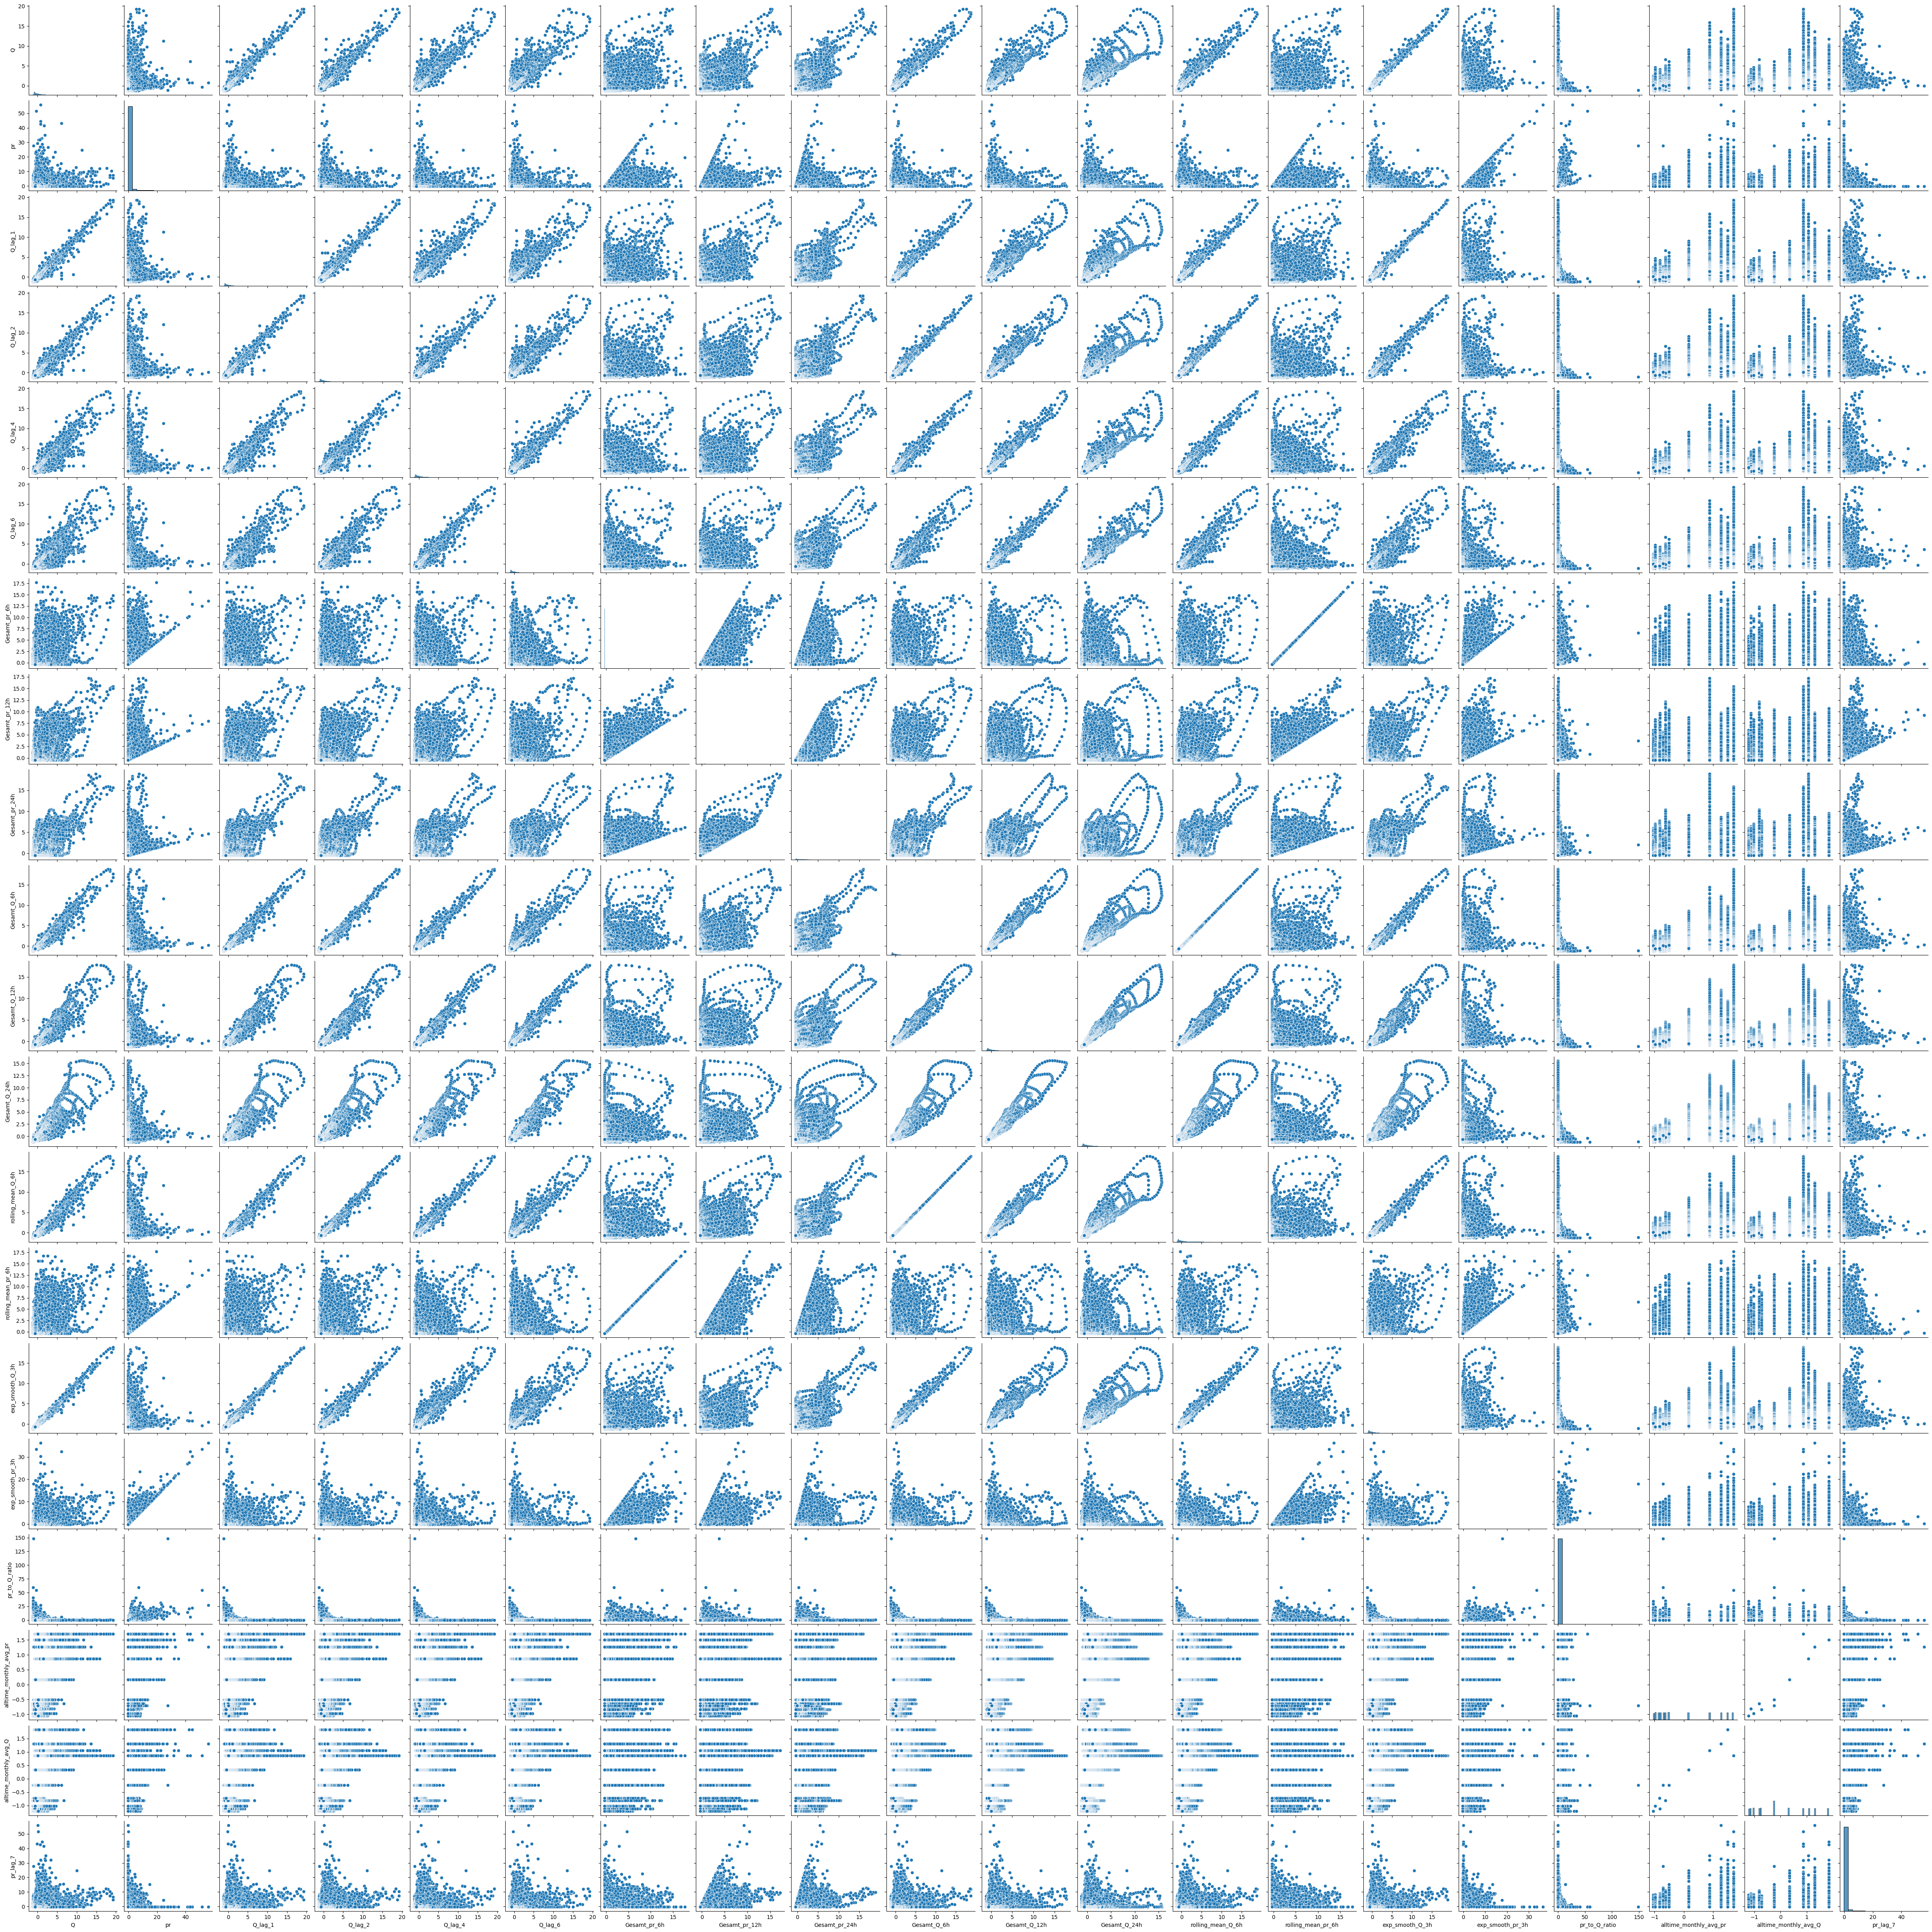

In [24]:
sns.pairplot(scaled_df)

With this, our data preparation is complete. Now, the training and testing of the models can be prepared. 
